## Compare Baseline GPT-4o and Fine-tuned Model Accuracy

In [1]:
import pandas as pd
import json
import re
import ast
import gpt_utils
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('/scratch/shared/image_ai_HHT_data/train.csv', 
                 usecols=['image', 'Class', 'Class Name'])

In [4]:
df['Ground Truth Year'] = df['Class Name'].apply(gpt_utils.extract_ground_truth_year)

In [5]:
df.head()

,Class,image,Class Name,Ground Truth Year
0,178,07149.jpg,Scion xD Hatchback 2012,2012
1,24,06852.jpg,Audi S4 Sedan 2007,2007
2,115,06627.jpg,Ford Focus Sedan 2007,2007
3,4,06099.jpg,Acura TL Type-S 2008,2008
4,105,05651.jpg,Fisker Karma Sedan 2012,2012


In [6]:
df['Ground Truth Year'].value_counts()

Ground Truth Year
2012    3373
2007     742
2009     377
2010     289
2011     217
2008     198
1993      98
1994      90
1998      64
2001      63
1991      32
2006      32
2000      32
2002      31
1999      31
1997      31
Name: count, dtype: int64

## Baseline Model Predictions

In [7]:
df_responses_base_model = pd.read_csv('results/responses_base_model.csv')

In [8]:
df_responses_base_model.head(2)

,id,custom_id,response,error
0,batch_req_6727e72a26a881909f3921898fa99cde,1206,"{'status_code': 200, 'request_id': '089527f77b936c6d16332489ff71808a', 'body': {'id': 'chatcmpl-APcAqw4Esa42GjYca947gd7rUmxtw', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a BMW from the year 2011.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 15, 'total_tokens': 475, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN
1,batch_req_6727e72a31f88190bbb27c90c1bd44f1,6497,"{'status_code': 200, 'request_id': '98ea4b58c03356156815a119073108a8', 'body': {'id': 'chatcmpl-APcAqI9GkvDZmHTsUIcHvaO8zIUnR', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 27, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN


In [9]:
df_responses_base_model = gpt_utils.post_process(df_responses_base_model)

In [10]:
df_responses_base_model.head(2)

,index,id,custom_id,response,error,content,extracted_years
0,0,batch_req_6727e72a26a881909f3921898fa99cde,1206,"{'status_code': 200, 'request_id': '089527f77b936c6d16332489ff71808a', 'body': {'id': 'chatcmpl-APcAqw4Esa42GjYca947gd7rUmxtw', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a BMW from the year 2011.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 15, 'total_tokens': 475, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,The car in the image is a BMW from the year 2011.,[2011]
1,1,batch_req_6727e72a31f88190bbb27c90c1bd44f1,6497,"{'status_code': 200, 'request_id': '98ea4b58c03356156815a119073108a8', 'body': {'id': 'chatcmpl-APcAqI9GkvDZmHTsUIcHvaO8zIUnR', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 27, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,"The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.","[2011, 2012, 2013]"


In [11]:
# Merge with labels

# Load labels from JSON file
with open('data/fine-tune/test_labels.json', 'r') as f:
    labels_dict = json.load(f)

# Convert labels_dict to a DataFrame
labels_df = pd.DataFrame(list(labels_dict.items()), columns=['index', 'Ground Truth Year'])
labels_df['index'] = labels_df['index'].astype(int)
labels_df['Ground Truth Year'] = labels_df['Ground Truth Year'].astype(str)

merged_df = pd.merge(df_responses_base_model, labels_df, on='index', how='left')

In [12]:
merged_df['Correct Prediction'] = merged_df.apply(lambda x: gpt_utils.is_correct_prediction(x['Ground Truth Year'], x['extracted_years']), 
                                              axis=1)

In [13]:
accuracy = merged_df['Correct Prediction'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.25%


In [14]:
merged_df.head(2)

,index,id,custom_id,response,error,content,extracted_years,Ground Truth Year,Correct Prediction
0,0,batch_req_6727e72a26a881909f3921898fa99cde,1206,"{'status_code': 200, 'request_id': '089527f77b936c6d16332489ff71808a', 'body': {'id': 'chatcmpl-APcAqw4Esa42GjYca947gd7rUmxtw', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a BMW from the year 2011.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 15, 'total_tokens': 475, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,The car in the image is a BMW from the year 2011.,[2011],2012,False
1,1,batch_req_6727e72a31f88190bbb27c90c1bd44f1,6497,"{'status_code': 200, 'request_id': '98ea4b58c03356156815a119073108a8', 'body': {'id': 'chatcmpl-APcAqI9GkvDZmHTsUIcHvaO8zIUnR', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 27, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,"The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.","[2011, 2012, 2013]",2012,True


In [15]:
# Convert 'custom_id' to string type before using string methods
merged_df['image_id'] = merged_df['custom_id'].astype(str).str.extract(r'(\d+)').astype(int)

In [16]:
merged_df.head(2)

,index,id,custom_id,response,error,content,extracted_years,Ground Truth Year,Correct Prediction,image_id
0,0,batch_req_6727e72a26a881909f3921898fa99cde,1206,"{'status_code': 200, 'request_id': '089527f77b936c6d16332489ff71808a', 'body': {'id': 'chatcmpl-APcAqw4Esa42GjYca947gd7rUmxtw', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a BMW from the year 2011.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 15, 'total_tokens': 475, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,The car in the image is a BMW from the year 2011.,[2011],2012,False,1206
1,1,batch_req_6727e72a31f88190bbb27c90c1bd44f1,6497,"{'status_code': 200, 'request_id': '98ea4b58c03356156815a119073108a8', 'body': {'id': 'chatcmpl-APcAqI9GkvDZmHTsUIcHvaO8zIUnR', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 27, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,"The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.","[2011, 2012, 2013]",2012,True,6497


In [17]:
df['image_id'] = df['image'].str.extract(r'(\d+)').astype(int)

In [18]:
final_df = pd.merge(merged_df, df[['image_id', 'Class Name']], on='image_id', how='left')

In [19]:
final_df.head(2)

,index,id,custom_id,response,error,content,extracted_years,Ground Truth Year,Correct Prediction,image_id,Class Name
0,0,batch_req_6727e72a26a881909f3921898fa99cde,1206,"{'status_code': 200, 'request_id': '089527f77b936c6d16332489ff71808a', 'body': {'id': 'chatcmpl-APcAqw4Esa42GjYca947gd7rUmxtw', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a BMW from the year 2011.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 15, 'total_tokens': 475, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,The car in the image is a BMW from the year 2011.,[2011],2012,False,1206,BMW 1 Series Coupe 2012
1,1,batch_req_6727e72a31f88190bbb27c90c1bd44f1,6497,"{'status_code': 200, 'request_id': '98ea4b58c03356156815a119073108a8', 'body': {'id': 'chatcmpl-APcAqI9GkvDZmHTsUIcHvaO8zIUnR', 'object': 'chat.completion', 'created': 1730668304, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 27, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_45cf54deae'}}",NaN,"The car in the image is a Honda Odyssey, and its design suggests it is from the years 2011 to 2013.","[2011, 2012, 2013]",2012,True,6497,Honda Odyssey Minivan 2012


In [20]:
final_df['Ground Truth Year'].value_counts()

Ground Truth Year
2012    10
2007    10
2008    10
2010    10
2011    10
1994    10
2009    10
1993    10
2001    10
2006    10
2002    10
1999    10
1997    10
1991    10
1998    10
2000    10
Name: count, dtype: int64

In [21]:
# Group by 'Class Name' and 'Correct Prediction' and count the occurrences
confusion = final_df.groupby(['Ground Truth Year', 'Correct Prediction']).size().reset_index(name='Count')

In [22]:
# Pivot the table to have 'Correct Prediction' as columns
confusion_pivot = confusion.pivot(index='Ground Truth Year', columns='Correct Prediction', values='Count').fillna(0)

# Ensure columns are ordered as False, True
confusion_pivot = confusion_pivot.reindex(columns=[False, True], fill_value=0)

# Print the confusion matrix-like table
print(confusion_pivot)

Correct Prediction  False  True 
Ground Truth Year               
1991                  0.0   10.0
1993                  1.0    9.0
1994                  7.0    3.0
1997                  3.0    7.0
1998                  0.0   10.0
1999                  2.0    8.0
2000                  4.0    6.0
2001                  2.0    8.0
2002                  3.0    7.0
2006                  0.0   10.0
2007                  4.0    6.0
2008                  1.0    9.0
2009                  1.0    9.0
2010                  3.0    7.0
2011                  5.0    5.0
2012                  2.0    8.0


In [23]:
# Compute total predictions per class
confusion_pivot['Total'] = confusion_pivot[False] + confusion_pivot[True]

# Compute accuracy per class
confusion_pivot['Accuracy'] = confusion_pivot[True] / confusion_pivot['Total']

# Display the confusion matrix with accuracy
print(confusion_pivot[[False, True, 'Total', 'Accuracy']])

Correct Prediction  False  True  Total  Accuracy
Ground Truth Year                               
1991                  0.0  10.0   10.0       1.0
1993                  1.0   9.0   10.0       0.9
1994                  7.0   3.0   10.0       0.3
1997                  3.0   7.0   10.0       0.7
1998                  0.0  10.0   10.0       1.0
1999                  2.0   8.0   10.0       0.8
2000                  4.0   6.0   10.0       0.6
2001                  2.0   8.0   10.0       0.8
2002                  3.0   7.0   10.0       0.7
2006                  0.0  10.0   10.0       1.0
2007                  4.0   6.0   10.0       0.6
2008                  1.0   9.0   10.0       0.9
2009                  1.0   9.0   10.0       0.9
2010                  3.0   7.0   10.0       0.7
2011                  5.0   5.0   10.0       0.5
2012                  2.0   8.0   10.0       0.8


## Plot Baseline Model Accuracy Per Year

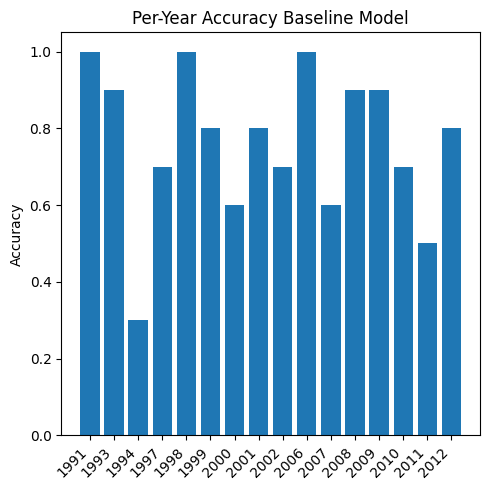

In [24]:
# Reset index to make 'Class Name' a column
confusion_pivot_reset = confusion_pivot.reset_index()

# Plot per-class accuracy
plt.figure(figsize=(5, 5))
plt.bar(confusion_pivot_reset['Ground Truth Year'], confusion_pivot_reset['Accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Per-Year Accuracy Baseline Model')
plt.tight_layout()
plt.show()

## Fine-tuned Model Predictions

In [25]:
df_responses_ft_model = pd.read_csv('results/responses_ft_model.csv')

In [26]:
df_responses_ft_model.head(2)

,id,custom_id,response,error
0,batch_req_6727f1023c7c8190a18ba1bc456b829f,1206,"{'status_code': 200, 'request_id': '66a29f9f23ee16c6d1b244e3ae899233', 'body': {'id': 'chatcmpl-APcm7TNFL10cp9SJgUpVLU8jANHsk', 'object': 'chat.completion', 'created': 1730670615, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN
1,batch_req_6727f1024ae08190a9b9f883eb352ce6,6497,"{'status_code': 200, 'request_id': 'e3b5c63154a588ffef8d25c9e5fe4098', 'body': {'id': 'chatcmpl-APcmBmJMqvvkPijhQ9RIcR8rO2HnI', 'object': 'chat.completion', 'created': 1730670619, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN


In [27]:
# Initialize a list to store extracted content
contents = []

for index, row in df_responses_ft_model.iterrows():
    json_str = row['response']

    try:
        # Remove the starting and ending double quotes if present
        if json_str.startswith('"') and json_str.endswith('"'):
            json_str = json_str[1:-1]

        # Safely evaluate the string as a Python literal
        response_dict = ast.literal_eval(json_str)
        # Navigate to the 'content' field
        content = response_dict['body']['choices'][0]['message']['content']
        # Store the content
        contents.append(content)
    except Exception as e:
        # In case of parsing error, append None
        contents.append(None)
        print(f"Error parsing row {index}: {e}")

# Add the extracted content to the DataFrame
df_responses_ft_model['content'] = contents

In [28]:
df_responses_ft_model.head()

,id,custom_id,response,error,content
0,batch_req_6727f1023c7c8190a18ba1bc456b829f,1206,"{'status_code': 200, 'request_id': '66a29f9f23ee16c6d1b244e3ae899233', 'body': {'id': 'chatcmpl-APcm7TNFL10cp9SJgUpVLU8jANHsk', 'object': 'chat.completion', 'created': 1730670615, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011
1,batch_req_6727f1024ae08190a9b9f883eb352ce6,6497,"{'status_code': 200, 'request_id': 'e3b5c63154a588ffef8d25c9e5fe4098', 'body': {'id': 'chatcmpl-APcmBmJMqvvkPijhQ9RIcR8rO2HnI', 'object': 'chat.completion', 'created': 1730670619, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011
2,batch_req_6727f10257e08190bf643214aed025b3,6436,"{'status_code': 200, 'request_id': '32ee6fe6646eebc12735caed550d72cc', 'body': {'id': 'chatcmpl-APcmENZycuaYXmkkzBRrLFxxci2i1', 'object': 'chat.completion', 'created': 1730670622, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2012', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 290, 'completion_tokens': 2, 'total_tokens': 292, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2012
3,batch_req_6727f10267448190a5b1c3af39aaf83a,2647,"{'status_code': 200, 'request_id': 'bcd77bb0caf4357420528671c1f60db2', 'body': {'id': 'chatcmpl-APcmH6JHqx9TaBwg0Mkq2LY0gijpo', 'object': 'chat.completion', 'created': 1730670625, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2012', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 290, 'completion_tokens': 2, 'total_tokens': 292, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2012
4,batch_req_6727f102748c81908af8a47eb66b47f5,5504,"{'status_code': 200, 'request_id': 'e27cf2963cc8a782e6d9e482db66bbc7', 'body': {'id': 'chatcmpl-APcmLxpVo6xNot6FpXD52w4GmqGr8', 'object': 'chat.completion', 'created': 1730670629, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011


In [29]:
df_responses_ft_model.shape

(160, 5)

In [30]:
df_responses_ft_model.reset_index(inplace=True)
df_responses_ft_model['index'] = df_responses_ft_model['index'].astype(int)

In [31]:
# Merge with labels

# Load labels from JSON file
with open('data/fine-tune/test_labels.json', 'r') as f:
    labels_dict = json.load(f)

# Convert labels_dict to a DataFrame
labels_df = pd.DataFrame(list(labels_dict.items()), columns=['index', 'Ground Truth Year'])
labels_df['index'] = labels_df['index'].astype(int)
labels_df['Ground Truth Year'] = labels_df['Ground Truth Year'].astype(str)

merged_df = pd.merge(df_responses_ft_model, labels_df, on='index', how='left')

print(merged_df[['index', 'Ground Truth Year', 'content']].head())


   index Ground Truth Year content
0      0              2012    2011
1      1              2012    2011
2      2              2012    2012
3      3              2012    2012
4      4              2012    2011


In [32]:
merged_df['Correct Prediction'] = merged_df.apply(lambda x: gpt_utils.is_correct_prediction(x['Ground Truth Year'], x['content']), 
                                              axis=1)

In [33]:
print(merged_df[['index', 'Ground Truth Year', 'content', 'Correct Prediction']].head())

   index Ground Truth Year content  Correct Prediction
0      0              2012    2011               False
1      1              2012    2011               False
2      2              2012    2012                True
3      3              2012    2012                True
4      4              2012    2011               False


In [34]:
accuracy = merged_df['Correct Prediction'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 86.88%


In [35]:
merged_df.head(2)

,index,id,custom_id,response,error,content,Ground Truth Year,Correct Prediction
0,0,batch_req_6727f1023c7c8190a18ba1bc456b829f,1206,"{'status_code': 200, 'request_id': '66a29f9f23ee16c6d1b244e3ae899233', 'body': {'id': 'chatcmpl-APcm7TNFL10cp9SJgUpVLU8jANHsk', 'object': 'chat.completion', 'created': 1730670615, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False
1,1,batch_req_6727f1024ae08190a9b9f883eb352ce6,6497,"{'status_code': 200, 'request_id': 'e3b5c63154a588ffef8d25c9e5fe4098', 'body': {'id': 'chatcmpl-APcmBmJMqvvkPijhQ9RIcR8rO2HnI', 'object': 'chat.completion', 'created': 1730670619, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False


In [36]:
# Convert 'custom_id' to string type before using string methods
merged_df['image_id'] = merged_df['custom_id'].astype(str).str.extract(r'(\d+)').astype(int)

In [37]:
merged_df.head(2)

,index,id,custom_id,response,error,content,Ground Truth Year,Correct Prediction,image_id
0,0,batch_req_6727f1023c7c8190a18ba1bc456b829f,1206,"{'status_code': 200, 'request_id': '66a29f9f23ee16c6d1b244e3ae899233', 'body': {'id': 'chatcmpl-APcm7TNFL10cp9SJgUpVLU8jANHsk', 'object': 'chat.completion', 'created': 1730670615, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False,1206
1,1,batch_req_6727f1024ae08190a9b9f883eb352ce6,6497,"{'status_code': 200, 'request_id': 'e3b5c63154a588ffef8d25c9e5fe4098', 'body': {'id': 'chatcmpl-APcmBmJMqvvkPijhQ9RIcR8rO2HnI', 'object': 'chat.completion', 'created': 1730670619, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False,6497


In [38]:
df['image_id'] = df['image'].str.extract(r'(\d+)').astype(int)

In [39]:
final_df = pd.merge(merged_df, df[['image_id', 'Class Name']], on='image_id', how='left')

In [40]:
final_df.head(2)

,index,id,custom_id,response,error,content,Ground Truth Year,Correct Prediction,image_id,Class Name
0,0,batch_req_6727f1023c7c8190a18ba1bc456b829f,1206,"{'status_code': 200, 'request_id': '66a29f9f23ee16c6d1b244e3ae899233', 'body': {'id': 'chatcmpl-APcm7TNFL10cp9SJgUpVLU8jANHsk', 'object': 'chat.completion', 'created': 1730670615, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False,1206,BMW 1 Series Coupe 2012
1,1,batch_req_6727f1024ae08190a9b9f883eb352ce6,6497,"{'status_code': 200, 'request_id': 'e3b5c63154a588ffef8d25c9e5fe4098', 'body': {'id': 'chatcmpl-APcmBmJMqvvkPijhQ9RIcR8rO2HnI', 'object': 'chat.completion', 'created': 1730670619, 'model': 'ft:gpt-4o-2024-08-06:gsb-darc-team::APcf7OZ4', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2011', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 460, 'completion_tokens': 2, 'total_tokens': 462, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'system_fingerprint': 'fp_4da243c00f'}}",NaN,2011,2012,False,6497,Honda Odyssey Minivan 2012


In [41]:
final_df['Ground Truth Year'].value_counts()

Ground Truth Year
2012    10
2007    10
2008    10
2010    10
2011    10
1994    10
2009    10
1993    10
2001    10
2006    10
2002    10
1999    10
1997    10
1991    10
1998    10
2000    10
Name: count, dtype: int64

In [42]:
len(set(final_df['Ground Truth Year']))

16

In [43]:
# Group by 'Class Name' and 'Correct Prediction' and count the occurrences
confusion = final_df.groupby(['Ground Truth Year', 'Correct Prediction']).size().reset_index(name='Count')

In [44]:
# Pivot the table to have 'Correct Prediction' as columns
confusion_pivot = confusion.pivot(index='Ground Truth Year', columns='Correct Prediction', values='Count').fillna(0)

# Ensure columns are ordered as False, True
confusion_pivot = confusion_pivot.reindex(columns=[False, True], fill_value=0)

# Print the confusion matrix-like table
print(confusion_pivot)

Correct Prediction  False  True 
Ground Truth Year               
1991                  1.0    9.0
1993                  0.0   10.0
1994                  0.0   10.0
1997                  0.0   10.0
1998                  0.0   10.0
1999                  0.0   10.0
2000                  0.0   10.0
2001                  0.0   10.0
2002                  0.0   10.0
2006                  0.0   10.0
2007                  4.0    6.0
2008                  1.0    9.0
2009                  5.0    5.0
2010                  5.0    5.0
2011                  2.0    8.0
2012                  3.0    7.0


In [45]:
# Compute total predictions per class
confusion_pivot['Total'] = confusion_pivot[False] + confusion_pivot[True]

# Compute accuracy per class
confusion_pivot['Accuracy'] = confusion_pivot[True] / confusion_pivot['Total']

# Display the confusion matrix with accuracy
print(confusion_pivot[[False, True, 'Total', 'Accuracy']])

Correct Prediction  False  True  Total  Accuracy
Ground Truth Year                               
1991                  1.0   9.0   10.0       0.9
1993                  0.0  10.0   10.0       1.0
1994                  0.0  10.0   10.0       1.0
1997                  0.0  10.0   10.0       1.0
1998                  0.0  10.0   10.0       1.0
1999                  0.0  10.0   10.0       1.0
2000                  0.0  10.0   10.0       1.0
2001                  0.0  10.0   10.0       1.0
2002                  0.0  10.0   10.0       1.0
2006                  0.0  10.0   10.0       1.0
2007                  4.0   6.0   10.0       0.6
2008                  1.0   9.0   10.0       0.9
2009                  5.0   5.0   10.0       0.5
2010                  5.0   5.0   10.0       0.5
2011                  2.0   8.0   10.0       0.8
2012                  3.0   7.0   10.0       0.7


## Plot Baseline Model Accuracy Per Year

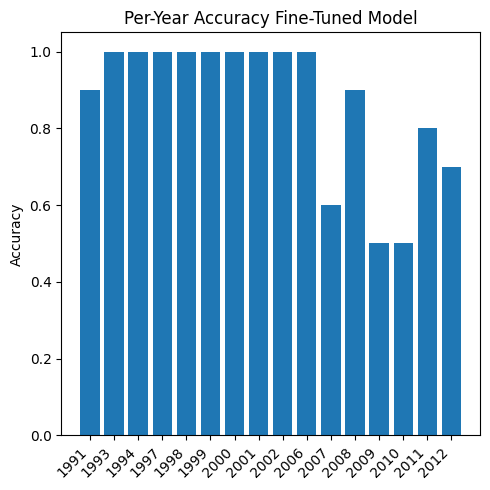

In [46]:
# Reset index to make 'Class Name' a column
confusion_pivot_reset = confusion_pivot.reset_index()

# Plot per-class accuracy
plt.figure(figsize=(5, 5))
plt.bar(confusion_pivot_reset['Ground Truth Year'], confusion_pivot_reset['Accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Per-Year Accuracy Fine-Tuned Model')
plt.tight_layout()
plt.show()